In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
application_train = pd.read_csv('../../../../homecredit/application_train.csv')
# POS= pd.read_csv("../../../../homecredit/POS_CASH_balance.csv")
# previous_application = pd.read_csv("../../../homecredit/previous_application.csv")
# credit_card_balance= pd.read_csv("../../../homecredit/credit_card_balance.csv")
instalments = pd.read_csv("../../../../homecredit/installments_payments.csv")

##### "Home credit"提供每位客戶的"每筆"貸款分期資料
##### 一個人可能有多筆貸款資料(1個SK_ID_CURR可能有多筆不同的SK_ID_PREV)
##### 貸款版本、合約分幾期、當期貸款應繳日期(距今多少天前)、當期貸款入帳日期(距今多少天前)、當期貸款應繳金額、當期貸款入帳金額

In [3]:
instalments = instalments.sort_values(by=['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER']) 
instalments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1478621,1369693,100001,1.0,1,-1709.0,-1715.0,3951.000,3951.000
2568722,1369693,100001,1.0,2,-1679.0,-1715.0,3951.000,3951.000
3458712,1369693,100001,1.0,3,-1649.0,-1660.0,3951.000,3951.000
2624024,1369693,100001,2.0,4,-1619.0,-1628.0,17397.900,17397.900
1761012,1851984,100001,1.0,2,-2916.0,-2916.0,3982.050,3982.050
...,...,...,...,...,...,...,...,...
12816277,2631384,456255,3.0,23,-96.0,-98.0,27489.690,27489.690
12164846,2631384,456255,4.0,24,-66.0,-76.0,308277.315,308277.315
12300604,2729207,456255,1.0,1,-469.0,-482.0,11514.555,11514.555
12567314,2729207,456255,1.0,2,-439.0,-455.0,11514.555,11514.555


In [4]:
#該欄位空值佔總比數幾%
instalments.isna().sum()/instalments.shape[0]

# DAYS_ENTRY_PAYMENT        2905
# AMT_PAYMENT               2905

SK_ID_PREV                0.000000
SK_ID_CURR                0.000000
NUM_INSTALMENT_VERSION    0.000000
NUM_INSTALMENT_NUMBER     0.000000
DAYS_INSTALMENT           0.000000
DAYS_ENTRY_PAYMENT        0.000214
AMT_INSTALMENT            0.000000
AMT_PAYMENT               0.000214
dtype: float64

In [5]:
# AMT_ENTRY_PAYMENT及AMT_PAYMENT兩個欄位空值的行數相同
both_columns_missing =(instalments[['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']].isnull().all(axis=1)).sum()
# 將Payment空值的欄位填入應繳欄位的值 == 無遲繳也無早繳
instalments['DAYS_ENTRY_PAYMENT'].fillna(instalments['DAYS_INSTALMENT'], inplace=True)
instalments['AMT_PAYMENT'].fillna(instalments['AMT_INSTALMENT'], inplace=True)
instalments.isna().sum()

SK_ID_PREV                0
SK_ID_CURR                0
NUM_INSTALMENT_VERSION    0
NUM_INSTALMENT_NUMBER     0
DAYS_INSTALMENT           0
DAYS_ENTRY_PAYMENT        0
AMT_INSTALMENT            0
AMT_PAYMENT               0
dtype: int64

<Axes: ylabel='Frequency'>

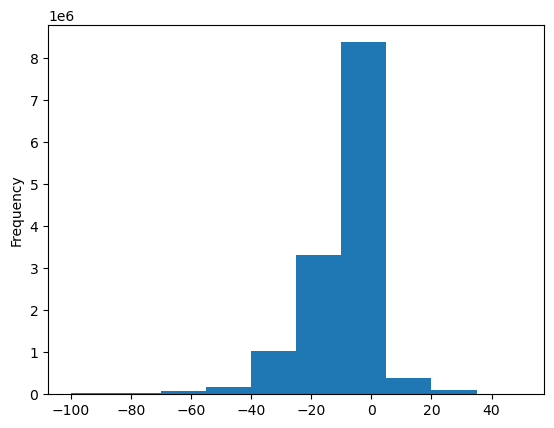

In [6]:
#overdue_DAY 正數為遲繳(天數)，負數為提前繳(天數)
overdue_DAY = instalments.DAYS_ENTRY_PAYMENT - instalments.DAYS_INSTALMENT
overdue_DAY.plot.hist(range=(-100,50))
#大部分繳款天數都提前30天內繳(合理)

0.013185719406579784

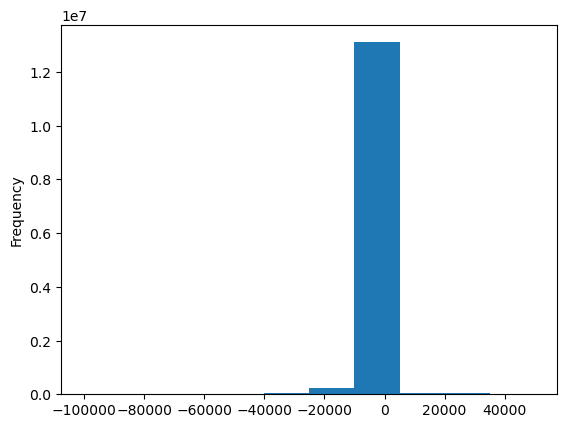

In [7]:
#overdue_AMT 正數表示多繳，負數表示少繳
overdue_AMT = instalments.AMT_PAYMENT -instalments.AMT_INSTALMENT
overdue_AMT.plot.hist(range=(-100000,50000))
(overdue_AMT>0).sum()/overdue_AMT.shape[0]
#竟然有期數多繳款，但總共179397筆，佔總筆數1.3%

<Axes: ylabel='Frequency'>

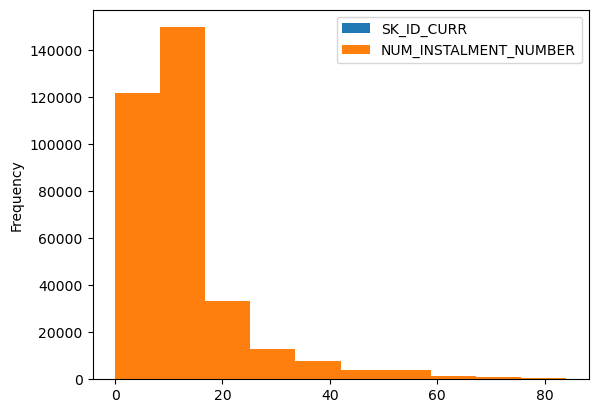

In [8]:
#計算每人的平均貸款期數
#每筆貸款的最大期數視為貸款總期數
#再依照人的ID計算貸款期數的平均
instalments_PREV_CNT = instalments.groupby('SK_ID_PREV').max()[['SK_ID_CURR','NUM_INSTALMENT_NUMBER']]
instalments_PERIOD = instalments_PREV_CNT.groupby('SK_ID_CURR').mean().reset_index()
instalments_PERIOD.plot.hist(range=(0,84))

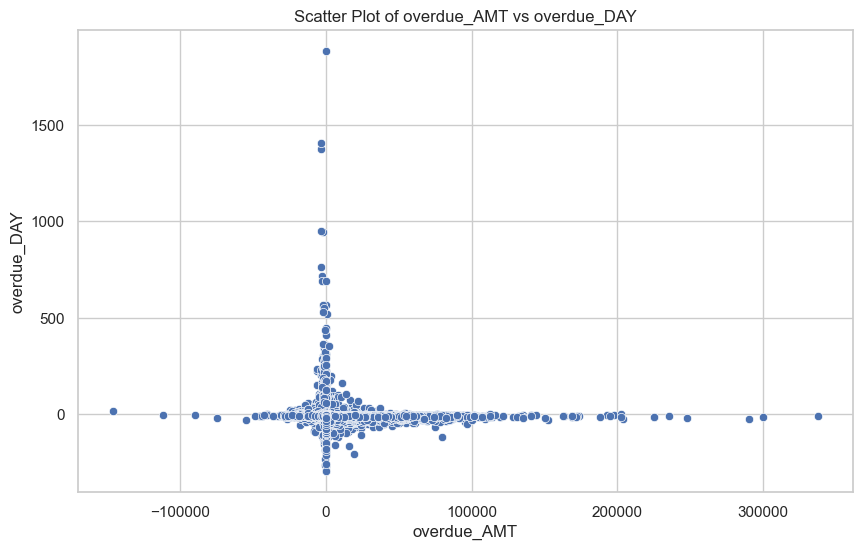

In [9]:
#合併到indstalments表格
instalments['overdue_DAY'] = overdue_DAY
instalments['overdue_AMT'] = overdue_AMT
instalments = instalments.groupby("SK_ID_CURR").mean().reset_index()
#overdue_DAY 正數為遲繳(天數)，負數為提前繳(天數)
#overdue_AMT 正數表示多繳，負數表示少繳
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=instalments, x='overdue_AMT', y='overdue_DAY')
plt.title('Scatter Plot of overdue_AMT vs overdue_DAY')
plt.xlabel('overdue_AMT')
plt.ylabel('overdue_DAY')
plt.show()

In [10]:
instalments_PERIOD= instalments_PERIOD.rename(columns={'NUM_INSTALMENT_NUMBER':'instalments_PERIOD'})
instalments = pd.merge(instalments,instalments_PERIOD,on='SK_ID_CURR')
instalments =instalments[['SK_ID_CURR','overdue_DAY' ,'overdue_AMT','instalments_PERIOD']]